In [0]:
# File location and type
file_location = "/FileStore/tables/censo/"
file_type = "parquet"

In [0]:
import pyarrow.parquet as pq
import pandas as pd
from pyspark.sql import SparkSession
from pyspark.sql.functions import sum

In [0]:
# Obtener la lista de archivos parquet en la ruta especificada
archivos_parquet = [file.path for file in dbutils.fs.ls(file_location) if file.path.endswith('.parquet')]

In [0]:
archivos_parquet

Out[16]: ['dbfs:/FileStore/tables/censo/colombia_personas_10.parquet',
 'dbfs:/FileStore/tables/censo/colombia_personas_11.parquet',
 'dbfs:/FileStore/tables/censo/colombia_personas_12.parquet',
 'dbfs:/FileStore/tables/censo/colombia_personas_13.parquet',
 'dbfs:/FileStore/tables/censo/colombia_personas_14.parquet',
 'dbfs:/FileStore/tables/censo/colombia_personas_15.parquet',
 'dbfs:/FileStore/tables/censo/colombia_personas_16.parquet',
 'dbfs:/FileStore/tables/censo/colombia_personas_17.parquet',
 'dbfs:/FileStore/tables/censo/colombia_personas_18.parquet',
 'dbfs:/FileStore/tables/censo/colombia_personas_19.parquet',
 'dbfs:/FileStore/tables/censo/colombia_personas_2.parquet',
 'dbfs:/FileStore/tables/censo/colombia_personas_20.parquet',
 'dbfs:/FileStore/tables/censo/colombia_personas_21.parquet',
 'dbfs:/FileStore/tables/censo/colombia_personas_22.parquet',
 'dbfs:/FileStore/tables/censo/colombia_personas_23.parquet',
 'dbfs:/FileStore/tables/censo/colombia_personas_24.parquet',


In [0]:
# Crear una sesión de Spark
spark = SparkSession.builder.getOrCreate()
from pyspark.sql.functions import count
from pyspark.sql.types import StringType, IntegerType, StructType, StructField
from pyspark.sql.functions import count, lit


In [0]:
# Esquema para el DataFrame de resultados
esquema = StructType([
    StructField("genero", StringType(), True),
    StructField("cantidad", IntegerType(), True)
])

# Crear DataFrame de resultado resumido
cantidad_total_por_genero = spark.createDataFrame(spark.sparkContext.emptyRDD(), esquema)

# Leer cada archivo parquet y calcular las estadísticas
total_registros = 0

for file in dbutils.fs.ls(file_location):
    if file.path.endswith('.parquet'):
        # Leer el archivo parquet
        df = spark.read.parquet(file.path)

        # Contar los registros
        registros_por_genero = df.groupBy('P_SEXO').agg(count('*').alias('cantidad'))

        # Contar los registros
        registros_por_genero = df.groupBy('P_SEXO').agg(count('*').alias('cantidad'))

        # Unir al DataFrame de resultado resumido
        cantidad_total_por_genero = cantidad_total_por_genero.union(registros_por_genero)

        # Actualizar el total de registros
        total_registros += df.count()

# Agregar una última operación de agregación para sumar la cantidad total por género
cantidad_total_por_genero = cantidad_total_por_genero.groupBy('genero').agg(sum('cantidad').alias('cantidad'))

# Mostrar los resultados
cantidad_total_por_genero.show()

In [0]:
# Contar los registros
registros_por_dpto = df.groupBy('U_DPTO').agg(count('*').alias('cantidad'))

# Contar los registros
registros_por_dpto = df.groupBy('U_DPTO').agg(count('*').alias('cantidad'))

# Unir al DataFrame de resultado resumido
cantidad_total_dpto = cantidad_total_dpto.union(registros_por_dpto)

# Actualizar el total de registros
total_dpto += df.count()

# Agregar una última operación de agregación para sumar la cantidad total por género
cantidad_por_Dpto = cantidad_total_dpto.groupBy('Departamento').agg(sum('cantidad').alias('cantidad')).orderBy('cantidad', ascending=False)
# Mostrar los resultados
cantidad_por_Dpto.show()

In [0]:
from pyspark.sql.functions import col, sum


# Calcular la proporción por género por departamento
personas_por_genero_departamento = personas_por_genero_municipio.groupBy('U_DPTO', 'P_SEXO').agg(
    sum('total_personas').alias('total_personas')
)

# Calcular el total de personas por departamento
personas_por_departamento = personas_por_genero_departamento.groupBy('U_DPTO').agg(
    sum('total_personas').alias('total_personas_departamento')
)

# Unir los resultados para obtener la proporción
personas_por_genero_departamento_proporcion = personas_por_genero_departamento.join(
    personas_por_departamento, 'U_DPTO'
).withColumn('proporcion_genero', col('total_personas') / col('total_personas_departamento'))

# Mostrar los resultados
print(f"Total de registros: {total_registros}")
print("Proporción de personas por género y departamento:")
personas_por_genero_departamento_proporcion.show()

In [0]:
from pyspark.sql.functions import col, sum as spark_sum

# Leer cada archivo Parquet y calcular el conteo de personas alfabetas igual a 2
df_resultado = None

for file in dbutils.fs.ls(file_location):
    if file.path.endswith('.parquet'):
        # Leer el archivo Parquet
        df = spark.read.parquet(file.path)

        # Filtrar personas que respondieron como alfabetas igual a 2 y realizar el conteo
        df_alfabetas = df.filter(df['P_ALFABETA'] == 2)
        df_contador = df_alfabetas.groupBy('U_DPTO').count().withColumnRenamed('count', 'total_analfabetas')

        # Calcular el total de personas por departamento
        df_totales = df.groupBy('U_DPTO').count().withColumnRenamed('count', 'total_personas')

        # Unir el conteo de personas alfabetas con los totales
        df_departamento = df_contador.join(df_totales, 'U_DPTO')

        # Calcular el índice de analfabetismo por departamento
        df_departamento = df_departamento.withColumn('indice_analfabetismo', col('total_analfabetas') / col('total_personas'))

        # Unir el resultado con el DataFrame general
        if df_resultado is None:
            df_resultado = df_departamento
        else:
            df_resultado = df_resultado.union(df_departamento)

# Calcular el total general por departamento
df_total_general = df_resultado.groupBy('U_DPTO').agg(
    spark_sum('total_analfabetas').alias('total_analfabetas_departamento'),
    spark_sum('total_personas').alias('total_personas_departamento')
)

# Calcular el índice de analfabetismo por departamento en el DataFrame final
df_resultado = df_resultado.join(df_total_general, 'U_DPTO').withColumn(
    'indice_analfabetismo', col('total_analfabetas_departamento') / col('total_personas_departamento')
)

# Ordenar el DataFrame final por el índice de analfabetismo de mayor a menor
df_resultado = df_resultado.orderBy(col('indice_analfabetismo').desc())

# Mostrar el DataFrame con los resultados
df_resultado.select('U_DPTO', 'total_personas_departamento', 'total_analfabetas_departamento', 'indice_analfabetismo') \
    .distinct() \
    .orderBy('indice_analfabetismo', ascending=False) \
    .limit(10) \
    .show()


+------+---------------------------+------------------------------+--------------------+
|U_DPTO|total_personas_departamento|total_analfabetas_departamento|indice_analfabetismo|
+------+---------------------------+------------------------------+--------------------+
|    44|                     825364|                        116909| 0.14164538312792901|
|    27|                     457412|                         61032|  0.1334289437093911|
|    99|                      76642|                          9030| 0.11782051616607082|
|    70|                     864036|                         94190| 0.10901166155113907|
|    23|                    1555596|                        159536| 0.10255619068189942|
|    47|                    1263788|                        112328| 0.08888199603097988|
|    20|                    1098577|                         93516| 0.08512466581768961|
|    97|                      37690|                          3178| 0.08431944812947731|
|    52|             

In [0]:
!pip install matplotlib pandas

You should consider upgrading via the '/local_disk0/.ephemeral_nfs/envs/pythonEnv-92e529e2-a4da-4384-b2bb-0efbefd6850e/bin/python -m pip install --upgrade pip' command.


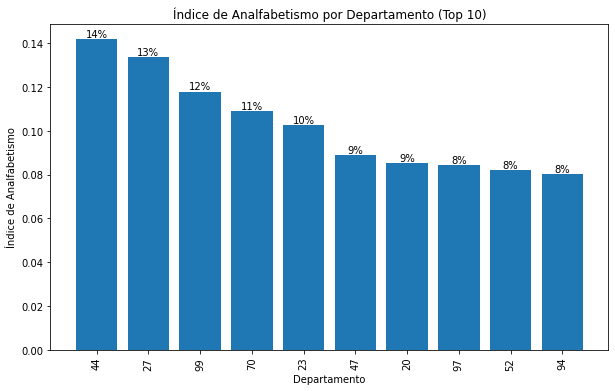

In [0]:
import matplotlib.pyplot as plt

df_sorted = df_pandas.sort_values('indice_analfabetismo', ascending=False).head(10)

# Crear el gráfico de barras con los 10 mayores índices de analfabetismo
plt.figure(figsize=(10, 6))
plt.bar(df_sorted['U_DPTO'], df_sorted['indice_analfabetismo'])
plt.xlabel('Departamento')
plt.ylabel('Índice de Analfabetismo')
plt.title('Índice de Analfabetismo por Departamento (Top 10)')
plt.xticks(rotation=90)

for i, value in enumerate(df_sorted['indice_analfabetismo']):
    formatted_value = '{:.0%}'.format(value)  
    plt.text(i, value, formatted_value, ha='center', va='bottom')

plt.show()